# Mean Reversion Strategy Bitcoin - Strategy

1. [Download Data](#download-data)
2. [Test Stationarity](#test-stationarity)
3. [Cointegration Test](#cointegration-test)
4. [Modeling the Strategy](#modeling-the-strategy)


# Download Data

Data can be downloaded from sources such as Yahoo Finance, Polygon, Metatrader...

---

C:\Users\jango\AppData\Local\Temp\ipykernel_44424\3700101628.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bitcoin = yf.download(
[*********************100%***********************]  1 of 1 completed
C:\Users\jango\AppData\Local\Temp\ipykernel_44424\3700101628.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  strategy = yf.download(
[*********************100%***********************]  1 of 1 completed


DatetimeIndex(['2024-06-17', '2024-06-18', '2024-06-20', '2024-06-21',
               '2024-06-24', '2024-06-25', '2024-06-26', '2024-06-27',
               '2024-06-28', '2024-07-01',
               ...
               '2025-06-02', '2025-06-03', '2025-06-04', '2025-06-05',
               '2025-06-06', '2025-06-09', '2025-06-10', '2025-06-11',
               '2025-06-12', '2025-06-13'],
              dtype='datetime64[ns]', name='Date', length=249, freq=None)
DatetimeIndex(['2024-06-17', '2024-06-18', '2024-06-20', '2024-06-21',
               '2024-06-24', '2024-06-25', '2024-06-26', '2024-06-27',
               '2024-06-28', '2024-07-01',
               ...
               '2025-06-02', '2025-06-03', '2025-06-04', '2025-06-05',
               '2025-06-06', '2025-06-09', '2025-06-10', '2025-06-11',
               '2025-06-12', '2025-06-13'],
              dtype='datetime64[ns]', name='Date', length=249, freq=None)


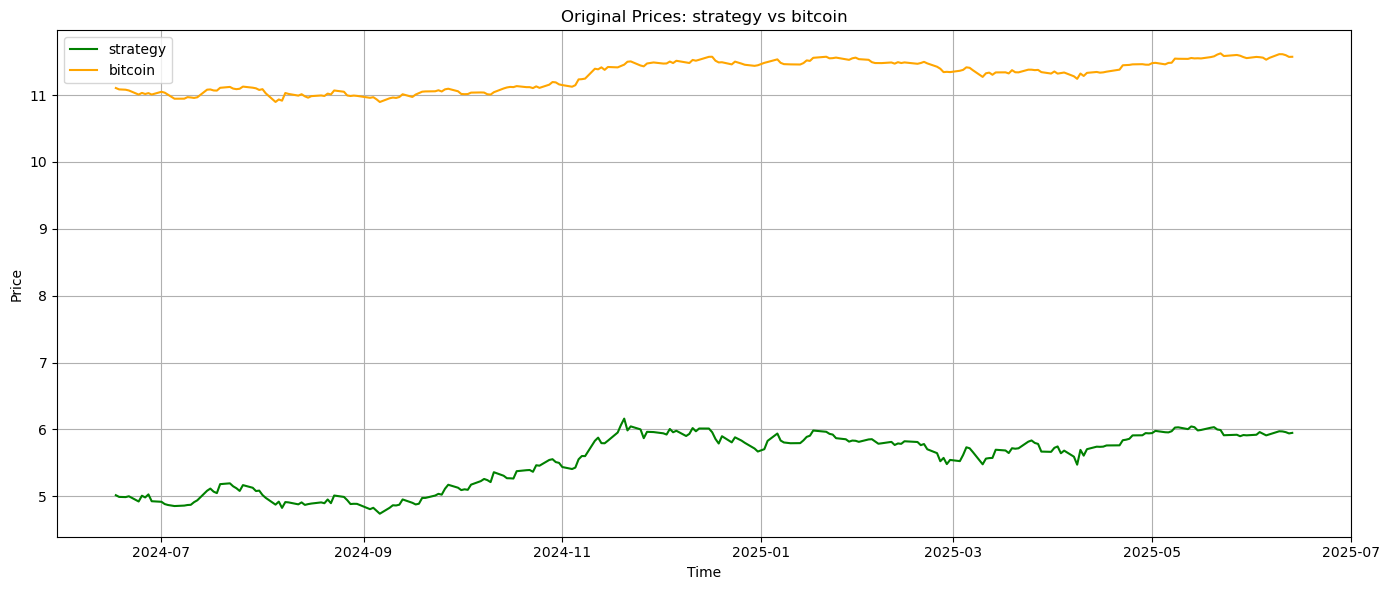

"\n# ======== Scatter plot of original prices: EWC vs EWA ===========\nplt.figure(figsize=(8, 6))\nplt.scatter(ewc['close'], ewa['close'], alpha=0.5, color='purple')\nplt.title('Scatter Plot: EWC vs EWA (Original Prices)')\nplt.xlabel('EWC Price')\nplt.ylabel('EWA Price')\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n"

In [100]:
# ===========================================
# Import required libraries
# ===========================================
import pandas as pd  # For data manipulation (install: pip install pandas)
import yfinance as yf  # Yahoo Finance API wrapper (install: pip install yfinance)
from datetime import datetime, timedelta  # To work with time ranges
from yahooquery import search  # For searching assets (install: pip install yahooquery)
import os  # To interact with the file system
import matplotlib.pyplot as plt  # For visualization (install: pip install matplotlib)
import json #For data manipulation
import numpy as np

# ===========================================
# Load environment variables
# ===========================================


bitcoin = yf.download(
    tickers= "BTC-USD",
    interval='1d',
    period='365d',
    progress=True,
    threads=True  # Enable multi-threading for faster downloading
)

strategy = yf.download(
    tickers= "MSTR",
    interval='1d',
    period='365d',
    progress=True,
    threads=True  # Enable multi-threading for faster downloading
)

bitcoin = np.log(bitcoin)
strategy = np.log(strategy)

common_dates = bitcoin.index.intersection(strategy.index)
bitcoin = bitcoin.loc[common_dates]
strategy = strategy.loc[common_dates]

print(bitcoin.index)
print(strategy.index)

# ======== Plot original prices: bitcoin vs strategy ===========
plt.figure(figsize=(14, 6))
plt.plot(strategy[('Close','MSTR')], label='strategy', color='green')
plt.plot(bitcoin[( 'Close','BTC-USD')], label='bitcoin', color='orange')
plt.title('Original Prices: strategy vs bitcoin')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

"""
# ======== Scatter plot of original prices: EWC vs EWA ===========
plt.figure(figsize=(8, 6))
plt.scatter(ewc['close'], ewa['close'], alpha=0.5, color='purple')
plt.title('Scatter Plot: EWC vs EWA (Original Prices)')
plt.xlabel('EWC Price')
plt.ylabel('EWA Price')
plt.grid(True)
plt.tight_layout()
plt.show()
"""


### Create Stationary Series Using OLS

The stationary series is calculated by subtracting the trend fitted by an Ordinary Least Squares (OLS) model, returning the residuals as the stationary series.

---

**Alpha**: The intercept term in the OLS regression, representing the constant part of the relationship between the two series.

**Beta**: The slope term in the OLS regression, representing the sensitivity of the dependent variable (the first asset) to the independent variable (the second asset). It indicates the strength and direction of the relationship between the two series.


C:\Users\jango\AppData\Local\Temp\ipykernel_44424\2980190915.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]  # The coefficient of the second asset (EWA)


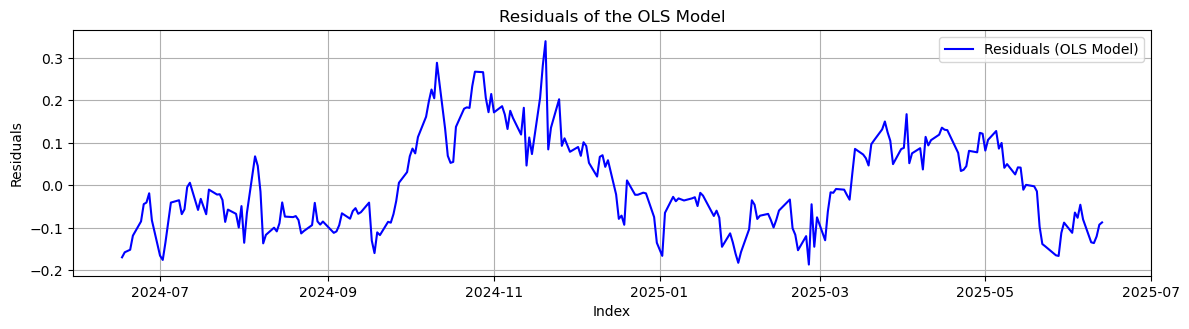

In [101]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from arch.__future__ import reindexing
from arch import unitroot

# Step 1: Define the dependent and independent variables
Y = strategy[('Close','MSTR')]
X = bitcoin[( 'Close','BTC-USD')]
X = sm.add_constant(X)  # Add an intercept (constant) to the model

# Step 2: Fit the OLS model
model = sm.OLS(Y, X).fit()
hedge_ratio = model.params[1]  # The coefficient of the second asset (EWA)

# residuals are the difference between the observed and predicted values from the model
residuals = model.resid  # Residuals from the OLS model

# Plot both the residuals from the OLS model and the manually calculated residuo
plt.figure(figsize=(12, 6))

# Plot residuals from the OLS model
plt.subplot(2, 1, 1)  # First plot
plt.plot(residuals, label='Residuals (OLS Model)', color='blue')
plt.title('Residuals of the OLS Model')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Test Stationarity

To test for stationarity, you can use the **Augmented Dickey-Fuller (ADF)** test (differents results depending on which is the independent variable).

---

In [102]:
from statsmodels.tsa.stattools import adfuller
from hurst import compute_Hc
from arch.unitroot import VarianceRatio

# Assume 'residuals' is already a list or 1D array-like series of residuals
# Example: residuals = [values from your cointegration model]

# --- ADF Test ---
adf_result = adfuller(residuals)
adf_statistic = adf_result[0]
adf_p_value = adf_result[1]

print("ADF Test:")
print(f"Statistic: {adf_statistic}")
print(f"P-value: {adf_p_value}")
if adf_p_value < 0.05:
    print("Residuals are stationary (reject null hypothesis of unit root).")
else:
    print("Residuals are not stationary (fail to reject null hypothesis).")

# Ensure residuals are strictly positive
residuals1 = [r - min(residuals) + 1 for r in residuals]


# --- Hurst Exponent --- Not recomended for 
H, c, _ = compute_Hc(residuals1, kind='price')
print("\nHurst Exponent:")
print(f"H: {H}")
if H < 0.5:
    print("Series shows mean-reverting behavior.")
elif H > 0.5:
    print("Series shows trending behavior.")
else:
    print("Series behaves like a random walk.")

# --- Variance Ratio Test ---
vr_test = VarianceRatio(residuals1, lags=2)
print("\nVariance Ratio Test:")
print(f"Variance Ratio: {vr_test.vr}")
print(f"P-value: {vr_test.pvalue}")
if vr_test.vr < 1:
    print("Variance ratio suggests mean reversion.")
elif vr_test.vr > 1:
    print("Variance ratio suggests momentum.")
else:
    print("Variance ratio suggests random walk.")




ADF Test:
Statistic: -3.1747335686830582
P-value: 0.021494578487692102
Residuals are stationary (reject null hypothesis of unit root).

Hurst Exponent:
H: 0.4028637231027633
Series shows mean-reverting behavior.

Variance Ratio Test:
Variance Ratio: 0.8553411141789827
P-value: 0.07581531283240861
Variance ratio suggests mean reversion.


## Half-Life for Mean Reverting Process

This section estimates the half-life of mean reversion for a stationary portfolio 
derived from cointegrated assets using the first eigenvector from the Johansen test.



In [103]:


# Construyes Y como matriz con columnas para cada activo
Y = pd.DataFrame({
    'strategy': strategy[('Close', 'MSTR')],
    'bitcoin': bitcoin[('Close', 'BTC-USD')]
})

# Multiply the eigenvector with the time series 'y3', repeat the eigenvector to match the shape of y3
# and sum the result across the specified axis (axis=1) to get 'yport'
yport = np.sum(np.tile(hedge_ratio, (Y.shape[0], 1)) * Y, axis=1)

# Create the lagged version of 'yport' (equivalent to lag(yport, 1) in MATLAB)
ylag = pd.Series(yport).shift(1)

# Calculate deltaY (the difference between 'yport' and its lagged version)
deltaY = yport - ylag

# Remove the first value, which is NaN due to the lag
deltaY = deltaY[1:]
ylag = ylag.dropna()  # Drop the NaN value from the lagged series

# Fit an OLS (Ordinary Least Squares) regression model
X = sm.add_constant(ylag)  # Add the constant term (intercept) to the independent variable
model = sm.OLS(deltaY, X)  # Create the OLS model with deltaY as the dependent variable and ylag as the independent variable
results_ols = model.fit()  # Fit the model

# Get the hedge ratio (beta[1]), which represents the coefficient for the lagged series
print(results_ols.params)

hedge_ratio = results_ols.params[0]

print(hedge_ratio)
# Calculate the half-life, which is the time it takes for the hedge ratio to halve
half_life = -np.log(2) / hedge_ratio

# Print the hedge ratio and the half-life in days
print(f'Hedge Ratio: {hedge_ratio}')
print(f'Half-Life: {half_life} days')



const    0.291532
0       -0.009196
dtype: float64
-0.009195642380261625
Hedge Ratio: -0.009195642380261625
Half-Life: 75.37778785827734 days


# Modeling the Strategy

You will use techniques such as z-scores, Bollinger Bands, and linear regression to model your strategy.

---

In [ ]:
"""
Y = pd.DataFrame({
    'strategy': strategy[('Close', 'MSTR')],
    'bitcoin': bitcoin[('Close', 'BTC-USD')]
})

# Step 1: Compute the portfolio value as the weighted sum of asset prices
yport = Y.iloc[:, 0] - hedge_ratio * Y.iloc[:, 1] 

# Step 2: Use the previously computed half-life as lookback period
lookback = round(half_life)

# Step 3: Define moving average and moving standard deviation functions
def moving_avg(x, window):
    return pd.Series(x).rolling(window=window, min_periods=1).mean().values

def moving_std(x, window):
    return pd.Series(x).rolling(window=window, min_periods=1).std().values

# Step 4: Compute z-score as signal (mean-reverting strategy)
zscore = (yport - moving_avg(yport, lookback)) / moving_std(yport, lookback)
entry_threshold = 1 # Only trade when z-score exceeds ±1

numUnits = np.where(np.abs(zscore) > entry_threshold, -zscore, 0)

weights = np.array([1, -hedge_ratio])

positions = pd.DataFrame(
    numUnits[:, None] * weights,  # shape (n, 2)
    index=Y.index,
    columns=['strategy', 'bitcoin']
)

# Step 6: Define lagging function (to avoid look-ahead bias)
def lag_matrix(mat, lag=1):
    lagged = np.roll(mat, lag, axis=0)
    lagged[:lag, :] = np.nan  # set initial values to NaN
    return lagged

# Step 7: Compute daily P&L (profit and loss)
positions_lag = lag_matrix(positions)
y3_lag = lag_matrix(Y)

# Calcula retornos logarítmicos diarios
daily_returns = (Y - y3_lag) /Y




# Step 9: Summary statistics
print(f"Average daily return: {np.nanmean(ret):.5f}")
print(f"Daily volatility: {np.nanstd(ret):.5f}")
print(f"Daily Sharpe ratio: {np.nanmean(ret)/np.nanstd(ret):.2f}")


# Drop NaNs for plotting
ret_clean = pd.Series(ret).dropna()

# Daily statistics
mean_daily_ret = np.mean(ret_clean)
std_daily_ret = np.std(ret_clean)
"""
#En Desarrollo



'\nY = pd.DataFrame({\n    \'strategy\': strategy[(\'Close\', \'MSTR\')],\n    \'bitcoin\': bitcoin[(\'Close\', \'BTC-USD\')]\n})\n\n# Step 1: Compute the portfolio value as the weighted sum of asset prices\nyport = Y.iloc[:, 0] - hedge_ratio * Y.iloc[:, 1] \n\n# Step 2: Use the previously computed half-life as lookback period\nlookback = round(half_life)\n\n# Step 3: Define moving average and moving standard deviation functions\ndef moving_avg(x, window):\n    return pd.Series(x).rolling(window=window, min_periods=1).mean().values\n\ndef moving_std(x, window):\n    return pd.Series(x).rolling(window=window, min_periods=1).std().values\n\n# Step 4: Compute z-score as signal (mean-reverting strategy)\nzscore = (yport - moving_avg(yport, lookback)) / moving_std(yport, lookback)\nentry_threshold = 1 # Only trade when z-score exceeds ±1\n\nnumUnits = np.where(np.abs(zscore) > entry_threshold, -zscore, 0)\n\nweights = np.array([1, -hedge_ratio])\n\npositions = pd.DataFrame(\n    numUnits[:,

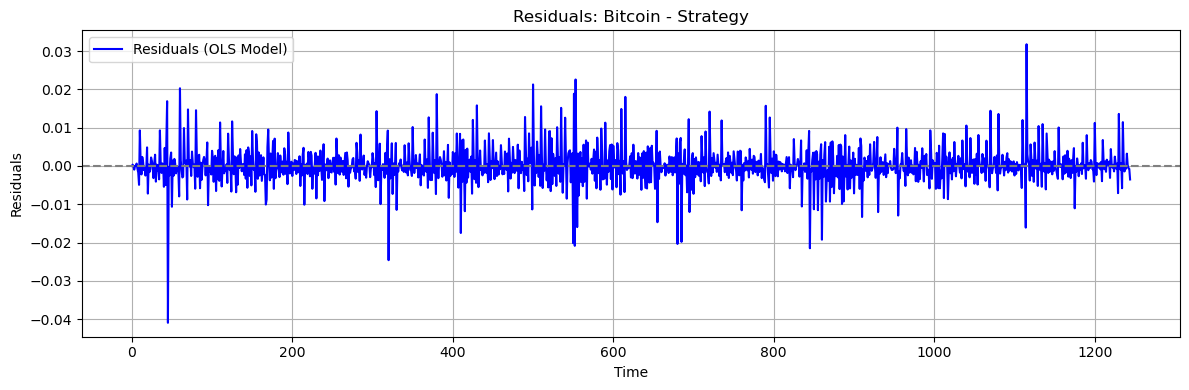

RangeIndex(start=0, stop=0, step=1)


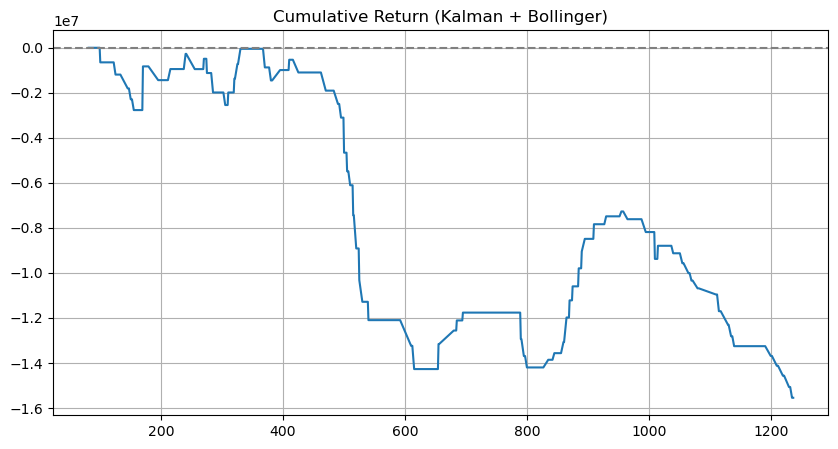

81          -0.032786
82           0.037918
96           0.003911
97          -0.045631
98           0.035319
            ...      
1231        -0.015297
1232         0.021113
1235   -478609.875812
1236        -0.026060
1237         0.028108
Name: ret, Length: 359, dtype: float64
Number of position changes: 368


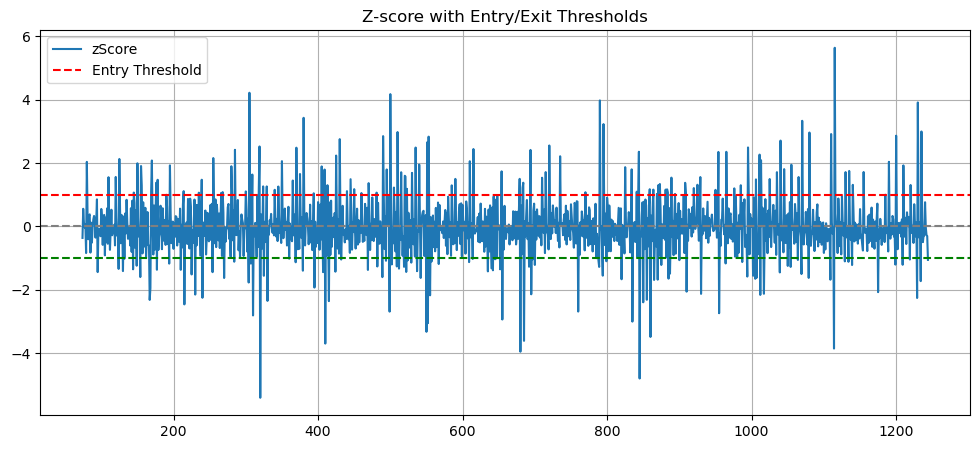

In [ ]:
# --- Kalman Filter Regression for Dynamic Hedge Ratio ---
def ensure_series(x, index):
    if isinstance(x, pd.Series):
        return x
    if isinstance(x, pd.DataFrame):
        x = x.iloc[:, 0]
    return pd.Series(x.flatten(), index=index)


def kalman_regression(x, y, delta=0.0001, Ve=0.001):
    x = np.hstack([x, np.ones((x.shape[0], 1))])  # Add intercept term
    yhat = np.full(y.shape, np.nan)
    e = np.full(y.shape, np.nan)
    Q = np.full(y.shape, np.nan)
    
    P = 1e5 * np.eye(2)
    beta = np.full((2, x.shape[0]), np.nan)
    Vw = (delta / (1 - delta)) * np.eye(2)
    beta[:, 0] = 0
    
    for t in range(len(y)):
        if t > 0:
            beta[:, t] = beta[:, t - 1]
            R = P + Vw
        else:
            R = P
        
        if Q[t] < 1e-10:
            Q[t] = 1e-10
        yhat[t] = x[t, :] @ beta[:, t]
        Q[t] = x[t, :] @ R @ x[t, :].T + Ve
        e[t] = y[t] - yhat[t]
        
        K = R @ x[t, :].T / Q[t]
        beta[:, t] = beta[:, t] + K * e[t]
        P = R - np.outer(K, x[t, :]) @ R

    return beta, yhat, e, Q


x = bitcoin.values.flatten()
y = strategy.values.flatten()

# Extract only price data, dates are not necessary here

# Apply the Kalman filter regression
beta, yhat, e, Q = kalman_regression(x.reshape(-1, 1), y)
hedge_ratio = beta[0, :]  # dynamic hedge ratio
intercept = beta[1, :]

# Calculate the spread
spread = y - hedge_ratio * x - intercept
spread = pd.Series(spread)  # convert to 1D Series


plt.figure(figsize=(12, 4))
plt.plot(spread, label='Residuals (OLS Model)', color='blue')
plt.axhline(y=0, linestyle='--', color='gray')
plt.title(f'Residuals: Bitcoin - Strategy')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Moving average and standard deviation functions
def moving_avg(x, window):
    return x.rolling(window=window).mean()

def moving_std(x, window):
    return x.rolling(window=window).std()

lookback = 75
entryZscore = 1
exitZscore = 0

zScore = (spread - moving_avg(spread, lookback)) / moving_std(spread, lookback)
# Generate trading signals
longsEntry = zScore < -entryZscore
longsExit = zScore >= -exitZscore
shortsEntry = zScore > entryZscore
shortsExit = zScore <= exitZscore

numUnitsLong = pd.Series(np.nan, index=spread.index)
numUnitsShort = pd.Series(np.nan, index=spread.index)

numUnitsLong.iloc[0] = 0
numUnitsLong[longsEntry] = 1
numUnitsLong[longsExit] = 0
numUnitsLong = numUnitsLong.ffill()  # Forward fill to maintain position until exit signal

numUnitsShort.iloc[0] = 0
numUnitsShort[shortsEntry] = -1
numUnitsShort[shortsExit] = 0
numUnitsShort = numUnitsShort.ffill()  # Forward fill as well

numUnits = numUnitsLong + numUnitsShort
positions = pd.DataFrame(index=spread.index)
print(positions.columns)
positions['bitcoin'] = numUnits
positions['strategy'] = -numUnits * hedge_ratio
# Number of units held for each asset

bitcoin = ensure_series(x, spread.index)
strategy = ensure_series(y, spread.index)

# Convert log-prices back to real prices
real_prices = np.exp(pd.DataFrame({
    'bitcoin': bitcoin,
    'strategy': strategy
}))

# Align indices and shift positions by one day to avoid lookahead bias
positions_lagged = positions.shift(1).reindex(real_prices.index).fillna(0)

# Calculate position values (notional value)
position_value = positions_lagged * real_prices

# Daily price changes
real_prices_diff = real_prices.diff().fillna(0)

# PnL: change in value of positions
pnl = (positions_lagged * real_prices_diff).sum(axis=1)

# Invested capital: sum of absolute position values
capital = position_value.abs().sum(axis=1)

# Returns: PnL divided by capital invested
ret = pnl / capital.replace(0, np.nan)

# Compile results into a DataFrame
results = pd.DataFrame({
    'pnl': pnl,
    'ret': ret,
    'zScore': zScore,
    'spread': spread
}).dropna(subset=['ret'])

# Calculate cumulative returns
results['cum_ret'] = results['ret'].cumsum()

# Plot cumulative returns
results['cum_ret'].plot(title='Cumulative Return (Kalman + Bollinger)', figsize=(10, 5))
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True)
plt.show()

# Print daily returns
print(results["ret"])

# Count the number of position changes (trades)
positions_diff = numUnits.diff().fillna(0)
num_trades = positions_diff[positions_diff != 0].count()
print(f"Number of position changes: {num_trades}")

# Plot z-score with entry and exit thresholds
plt.figure(figsize=(12, 5))
plt.plot(zScore, label='zScore')
plt.axhline(entryZscore, color='red', linestyle='--', label='Entry Threshold')
plt.axhline(-entryZscore, color='green', linestyle='--')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.title('Z-score with Entry/Exit Thresholds')
plt.grid(True)
plt.show()


# Strategy Results and interpretation

Evaluate the strategy's performance using metrics like returns, Sharpe ratio, and drawdowns.

In [ ]:

#EN DESARROLLO
"""
# Daily statistics
mean_daily_ret = np.mean(ret_clean)
std_daily_ret = np.std(ret_clean)

# Annualized statistics
annualized_return = (1 + mean_daily_ret)**252 - 1
annualized_volatility = std_daily_ret * np.sqrt(252)
sharpe_ratio_annual = annualized_return / annualized_volatility

# Output
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Annualized Sharpe Ratio: {sharpe_ratio_annual:.2f}")

# Plot daily returns
plt.figure(figsize=(12, 5))
plt.plot(ret_clean.index, ret_clean, label='Daily Returns', color='skyblue')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Daily Returns of Mean-Reverting Strategy')
plt.xlabel('Time')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()

# Plot cumulative returns
cumulative_returns = (1 + ret_clean).cumprod()

plt.figure(figsize=(12, 5))
plt.plot(cumulative_returns.index, cumulative_returns, label='Cumulative Returns', color='green')
plt.title('Cumulative Returns of Mean-Reverting Strategy')
plt.xlabel('Time')
plt.ylabel('Portfolio Value (Normalized)')
plt.legend()
plt.grid(True)
plt.show()
"""




NameError: name 'ret_clean' is not defined

#### Strategy Evaluation

##### Insufficient Return Relative to Risk
Although the **annual volatility** is low (2.98%), the **annualized return of 1.10%** does not remotely compensate for the risk taken.  
A **Sharpe ratio of 0.37** indicates that the strategy is generating very little excess return per unit of risk, making it unattractive.

##### Near Zero Daily Return
A **daily average return of just 0.004%** suggests the model has not captured mean-reversion signals effectively.  
It might be operating in an environment where the relationship between assets has **structurally changed**.

##### Signal or Parameter Issues
It is possible that the **half-life estimation**, or the use of the **first principal component (PCA)**, is not generating a solid signal.  
The linear combination of the portfolio might not exhibit sufficiently **mean-reverting behavior**.

##### Transaction Costs Not Included
With such low volatility, it's likely that when **transaction costs** (spreads, commissions) are included, the strategy would be **directly losing money**.

##### Inadequate Period or Assets
The **EWA, EWC, IGE** ETF pair might not show stable or cointegrated relationships over this period.  
It may be necessary to **re-evaluate asset selection** or the **training window**.

---

#### Recommendations for Improvement

- **Check for cointegration** between the assets using statistical tests like ADF or Johansen.
- **Experiment with other linear combinations**, such as using cointegration vectors instead of PCA.
- **Optimize the lookback period** or implement a **dynamic z-score strategy**.
- Include **mechanical stop-loss and take-profit**
- **Check for skewness in the mean**
